Optical flow calculation failed for frame 156. Skipping..
Optical flow calculation failed for frame 190. Skipping..


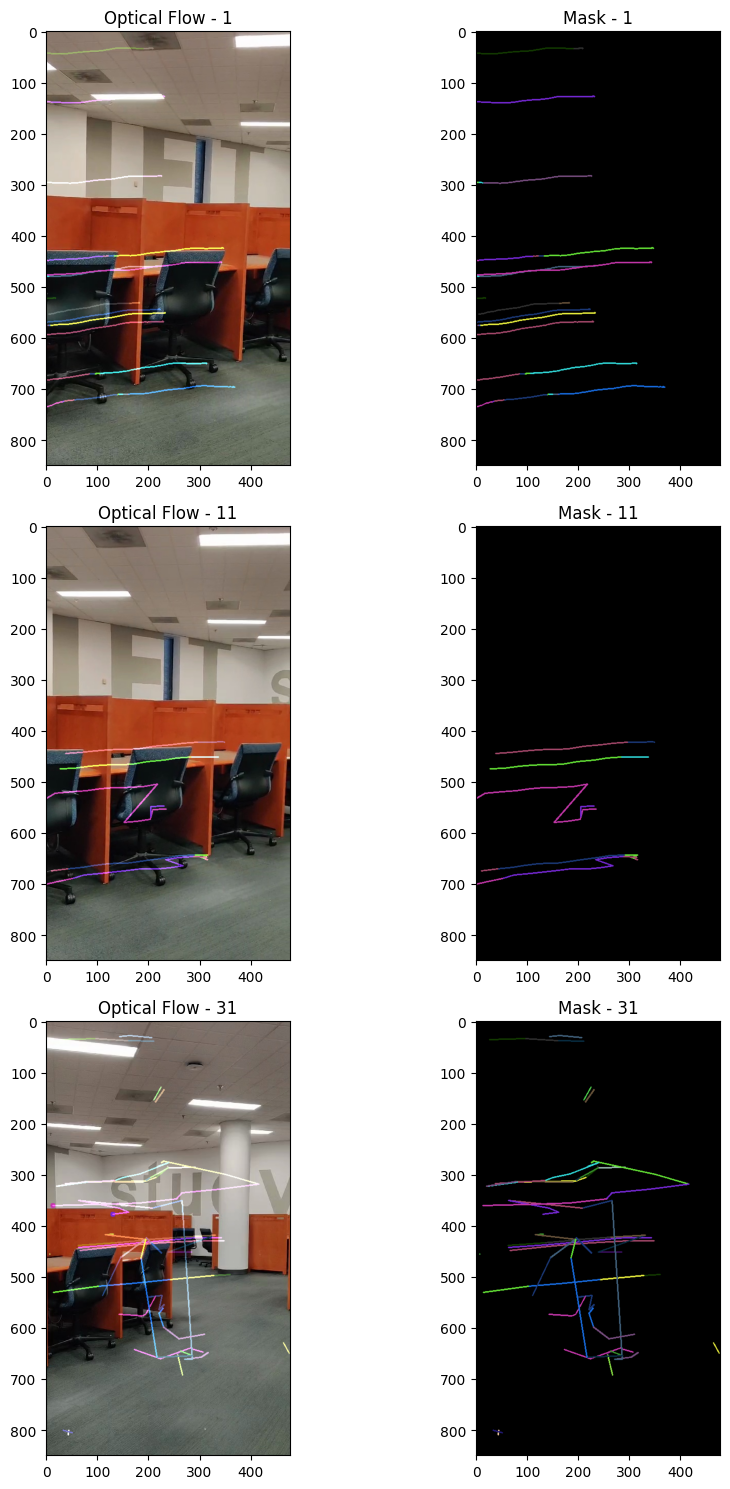

In [1]:
import cv2
import numpy as np
import os
from pathlib import Path
import re
import matplotlib.pyplot as plt

# Function for sorting the video frames into order
def sort_frames_numerically(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

# Taking a frame at a time and appending into img_array in numerical order
def load_frames(video_frames_folder):
    frame_array = []
    for filename in sorted(os.listdir(video_frames_folder), key=sort_frames_numerically):
        frame = cv2.imread(os.path.join(video_frames_folder, filename))
        frame_array.append(frame)
    return frame_array

# Initializing certain parameters
def initialize_params():
    # ShiTomasi corner detection parameters
    shi_tomasi_params = dict(maxCorners=100,
                             qualityLevel=0.3,
                             minDistance=7,
                             blockSize=7)

    # Lucas-Kanade optical flow parameters
    lk_params = dict(winSize=(15, 15),
                     maxLevel=2,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # Create some random colors
    color = np.random.randint(0, 255, (100, 3))

    return shi_tomasi_params, lk_params, color

# Make sure the destination path is present before starting to store the examples
def create_output_folder(output_folder):
    Path(output_folder).mkdir(parents=True, exist_ok=True)

'''
    Plots the optical flow vectors on each frame
    treating every nth frame as a reference frame
    default: every previous frame (n = 1)
'''
def plot_optical_flow(frame_array, shi_tomasi_params, lk_params, color, output_folder, n=1):
    # Take first frame from frame array and
    # find good corners in it
    old_gray = cv2.cvtColor(frame_array[0], cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **shi_tomasi_params)

    # Create a mask image for drawing purposes
    mask = np.zeros_like(frame_array[0])

    # For each frame in frame_array,
    # find corners and compare with previous frame
    for frame_index, frame in enumerate(frame_array[::n]):
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        if p1 is None:
            print(f"Optical flow calculation failed for frame {frame_index * n}. Skipping..")
            break

        # Select good points
        good_new = p1[st == 1]
        good_old = p0[st == 1]

        # Draw the tracks
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
            frame = cv2.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
        img = cv2.add(frame, mask)

        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)

    # Save the result
    cv2.imwrite(f"{output_folder}/{n}.png", img)
    cv2.imwrite(f"{output_folder}/{n}_mask.png", mask)

    return img, mask

# Main function
def main():
    video_frames_folder = 'frames'
    output_folder = "./optical_flow/"

    frame_array = load_frames(video_frames_folder)
    create_output_folder(output_folder)
    shi_tomasi_params, lk_params, color = initialize_params()

    # Treating every previous frame as a reference frame
    img_1, mask_1 = plot_optical_flow(frame_array, shi_tomasi_params, lk_params, color, output_folder)

    # Treating every 11th frame as a reference frame
    img_11, mask_11 = plot_optical_flow(frame_array, shi_tomasi_params, lk_params, color, output_folder, n=10)

    # Treating every 31st frame as a reference frame
    img_31, mask_31 = plot_optical_flow(frame_array, shi_tomasi_params, lk_params, color, output_folder, n=30)

    # Display the saved images
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))

    axes[0, 0].imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title("Optical Flow - 1")

    axes[0, 1].imshow(cv2.cvtColor(mask_1, cv2.COLOR_BGR2RGB))
    axes[0, 1].set_title("Mask - 1")

    axes[1, 0].imshow(cv2.cvtColor(img_11, cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title("Optical Flow - 11")

    axes[1, 1].imshow(cv2.cvtColor(mask_11, cv2.COLOR_BGR2RGB))
    axes[1, 1].set_title("Mask - 11")

    axes[2, 0].imshow(cv2.cvtColor(img_31, cv2.COLOR_BGR2RGB))
    axes[2, 0].set_title("Optical Flow - 31")

    axes[2, 1].imshow(cv2.cvtColor(mask_31, cv2.COLOR_BGR2RGB))
    axes[2, 1].set_title("Mask - 31")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()